In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.impute import KNNImputer
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression,f_regression
from skfeature.function.similarity_based import fisher_score 
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
import json,pickle

# 1. Problem Statement

In [2]:
"""Oxygen shortage was one of the prime causes of increasing death cases of Covid 
infected patients in India. That's why the client wants to develop a strategy to 
deliver oxygen in an efficient way so that it gets utilized to its fullest and 
sustainably, thus reventing acute shortages of O2."""

# Predict the oxygen demand for various categories of patients within a given span of time and duration.
# (Oxygen demand for patients with acute respiratory syndromes)

"Oxygen shortage was one of the prime causes of increasing death cases of Covid \ninfected patients in India. That's why the client wants to develop a strategy to \ndeliver oxygen in an efficient way so that it gets utilized to its fullest and \nsustainably, thus reventing acute shortages of O2."

# 2. Data Gathering & Validation

In [3]:
df = pd.read_csv("Oxygen_demand.csv").sample(5000)
df.head()

,age,gender,spo2,pr,c/nc,oxy_flow
95433,79,1,97.0,110.0,1.0,0.0
4575,17,0,NaN,54.0,1.0,29.0
124923,17,0,NaN,49.0,1.0,6.0
64585,41,0,99.0,108.0,1.0,76.0
99308,70,0,81.0,104.0,1.0,0.0


In [4]:
# Feature information

# age: The exact age of the patient concerned(in year)
# gender: gender of patient concerned (0 for female and 1 for male)
# spo2: The instantaneous oxygen saturation percentage of the patient concerned
# pr: The instantaneous pulse rate of the patient concerned
# c/nc: A categorical data categorizing the patient as infected with SARS (positive(1.0)/negative(0.0))

# Oxygen Flow: Doctor-prescribed instantaneous oxygen flow concentration of the patient concerned (Target variable)


# 3. EDA

In [5]:
df.describe().drop(["gender","c/nc"], axis = 1) # All the stats of the data (except gender & c/nc: categorical)

,age,spo2,pr,oxy_flow
count,5000.00000,4305.000000,4158.000000,5000.000000
mean,46.32620,88.521719,92.516354,18.817000
std,21.30159,15.436254,15.944654,17.828008
min,17.00000,35.000000,40.000000,0.000000
25%,29.00000,83.000000,82.000000,7.000000
50%,43.00000,97.000000,95.000000,16.000000
75%,61.00000,99.000000,107.000000,25.000000
max,100.00000,99.000000,110.000000,76.000000


In [6]:
df.info() # information of the featuers

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 95433 to 121780
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       5000 non-null   int64  
 1   gender    5000 non-null   int64  
 2   spo2      4305 non-null   float64
 3   pr        4158 non-null   float64
 4   c/nc      5000 non-null   float64
 5   oxy_flow  5000 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 273.4 KB


In [7]:
(df.isna().sum()/200000)*100 # checking for % null values

age         0.0000
gender      0.0000
spo2        0.3475
pr          0.4210
c/nc        0.0000
oxy_flow    0.0000
dtype: float64

In [8]:
#cheking for unique values
for i in df.columns:
    print(f"unique values of {i}:: {df[i].nunique()}")

unique values of age:: 84
unique values of gender:: 2
unique values of spo2:: 65
unique values of pr:: 70
unique values of c/nc:: 2
unique values of oxy_flow:: 77


<AxesSubplot:title={'center':'pr distribution'}, ylabel='Density'>

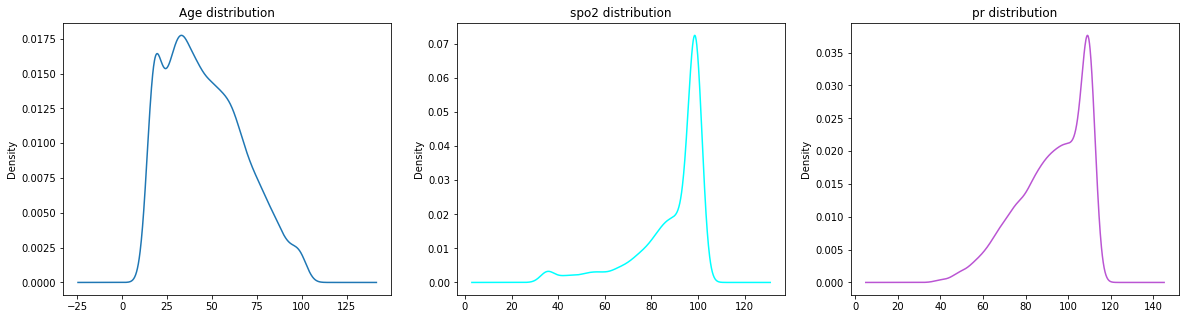

In [9]:
# checking the distribution of the data
fig, axes = plt.subplots(1, 3, figsize=(20,5))
df.age.plot(kind = "kde",ax = axes[0],title ="Age distribution" ) 
df.spo2.plot(kind = "kde",ax = axes[1],color = "aqua", title = "spo2 distribution")
df.pr.plot(kind ="kde",ax = axes[2],color = "mediumorchid", title = "pr distribution")

In [10]:
# checking in which gender the infected and disinfect patient with SARS needs how much avg age
df.pivot_table(index = "c/nc", columns = "gender", values = "age"  )

gender,0,1
c/nc,,
0.0,44.789165,44.446281
1.0,47.231973,45.844711


In [11]:
# avg age in each gender
df.groupby("gender").mean()["age"]

gender
0    46.726998
1    45.545401
Name: age, dtype: float64

In [12]:
# avg age of infected and disinfect patient with SARS in each gender
df.groupby(["gender","c/nc"]).mean()["age"]

gender  c/nc
0       0.0     44.789165
        1.0     47.231973
1       0.0     44.446281
        1.0     45.844711
Name: age, dtype: float64

<AxesSubplot:ylabel='age'>

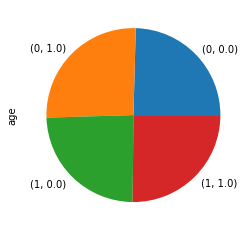

In [13]:
# bar graph of avg age of infected and disinfect patient with SARS in each gender
df.groupby(["gender","c/nc"]).mean()["age"].plot(kind ='pie')

In [14]:
# cheking either male or female needs more oxygen
df.groupby("gender").sum()['oxy_flow']

gender
0    61227.0
1    32858.0
Name: oxy_flow, dtype: float64

In [15]:
# total oxygen, and avg oxygen flow in each category who is infected and 
# disinfacted with Severe acute respiratory syndrome (SARS)
df.groupby("c/nc")["oxy_flow"].agg(["mean","sum"])

,mean,sum
c/nc,,
0.0,19.437859,20332.0
1.0,18.652757,73753.0


<AxesSubplot:xlabel='gender', ylabel='age'>

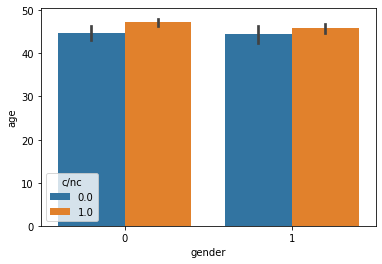

In [16]:
# bar plot of ages in each sars infected and disinfacted males and feamales
sns.barplot(x = "gender", y = "age",hue = "c/nc", data = df)

In [17]:
# checking in which gender and in which age category how many patients need how much oxy_flow
pd.crosstab(index =df.age ,columns =[df.gender,df.oxy_flow])

gender      0                                               ...    1       \
oxy_flow 0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0   ... 67.0 68.0   
age                                                         ...             
17         24    2    7    4    5    6    8    4    9    7  ...    0    1   
18          4    0    0    0    0    1    0    0    0    0  ...    0    0   
19          7    1    0    1    0    0    0    1    2    0  ...    0    0   
20          4    0    0    1    1    1    0    1    1    1  ...    1    0   
21          2    1    0    1    0    1    2    0    2    1  ...    0    0   
..        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
96          4    0    0    1    0    0    1    0    0    0  ...    0    0   
97          3    0    0    0    0    1    0    1    0    0  ...    0    0   
98          3    0    0    0    0    0    0    0    0    1  ...    1    0   
99          1    0    0    1    0    0    0    1    0    0  ...    0    0   
100         7    1    0    2    0    1    1    2    1    1  ...    0    0   

gender                                            
oxy_flow 69.0 70.0 71.0 72.0 73.0 74.0 75.0 76.0  
age                                               
17          0    0    0    0    0    0    0   12  
18          0    0    0    0    0    0    0    0  
19          0    0    0    0    0    0    0    0  
20          0    0    0    0    0    0    0    0  
21          0    0    0    0    0    0    0    0  
..        ...  ...  ...  ...  ...  ...  ...  ...  
96          0    0    0    0    0    0    0    0  
97          0    0    0    0    0    0    0    0  
98          0    0    0    0    0    0    0    0  
99          0    0    0    0    0    0    0    0  
100         0    0    0    0    1    0    0    1  

[84 rows x 152 columns]

<AxesSubplot:xlabel='pr'>

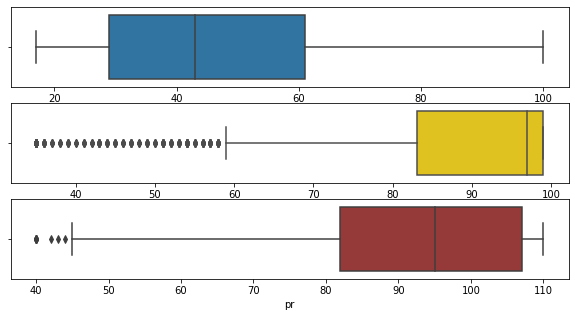

In [18]:
# checking for outliers
fig, axes = plt.subplots(3, 1, figsize=(10, 5))
sns.boxplot(df["age"],ax = axes[0])
sns.boxplot(df["spo2"], ax = axes[1],color = "gold")
sns.boxplot(df["pr"], ax = axes[2],color = "brown")

###### So now we have all the insights of the data. Here we have to handle null values as well as outliers. So now the time to do featuer engineering 

# 4. Feature Engineering

In [19]:
# first we will handle null values.
# We can fill null values with mean, but knn-imputer is one of the best choice so we will use it.
knn = KNNImputer()
arr = knn.fit_transform(df)
df1 = pd.DataFrame(arr, columns = df.columns)
df1.head()

,age,gender,spo2,pr,c/nc,oxy_flow
0,79.0,1.0,97.0,110.0,1.0,0.0
1,17.0,0.0,98.8,54.0,1.0,29.0
2,17.0,0.0,81.8,49.0,1.0,6.0
3,41.0,0.0,99.0,108.0,1.0,76.0
4,70.0,0.0,81.0,104.0,1.0,0.0


In [20]:
df1.isna().sum()

age         0
gender      0
spo2        0
pr          0
c/nc        0
oxy_flow    0
dtype: int64

In [21]:
# now we use z_score for finding the outliers
# Normal SpO2 values vary between 90 and 100%

z_val = stats.zscore(df1["spo2"])
z_val = np.abs(z_val)
threshold = 3
outliers = np.where(z_val >= threshold)
df1["spo2"][outliers[0]]

23      36.0
126     43.0
191     36.0
209     37.0
226     35.0
        ... 
4816    35.0
4834    35.0
4882    37.0
4937    35.0
4984    42.0
Name: spo2, Length: 147, dtype: float64

In [22]:
# A normal pulse rate for adults is between 60 and 100 beats per minute.
# Similar to spo2 we will use scaling for pr feature also.

z_scr = stats.zscore(df1["pr"])
z_scr = np.abs(z_scr)
threshold = 3
outliers1 = np.where(z_scr >= threshold)
df1["pr"][outliers1[0]]

89      46.0
132     40.0
294     40.0
370     40.0
1229    40.0
2194    47.0
2324    43.0
2434    46.0
2557    47.0
2748    42.0
2833    40.0
2834    45.0
3055    40.0
3195    40.0
3590    40.0
3593    40.0
3898    47.0
3989    46.0
4011    45.0
4290    44.0
4615    46.0
4810    47.0
Name: pr, dtype: float64

###### let's check the mean value of the featuer, wich is 88. But  if we replace outliers with 88 so it will be around normal range.
###### So we will not handle outliers because we needs actual information.  But we can reduce the impact by using scaling.

# 5. Feature Selection

In [23]:
# less corellation between depedent and independent variables
df1.corr()[-1:][["age","spo2","pr"]] #(independent cont and dependent cont) 

,age,spo2,pr
oxy_flow,-0.068582,-0.014289,-0.079262


In [24]:
# less corellation between dependent and independent variables
df1.corr(method = "kendall")[-1:][["gender","c/nc"]] # (independent cat and dependent con)

,gender,c/nc
oxy_flow,0.032172,-0.018875


In [25]:
# taking mutual information # telling all the featuers are giving information exept c/nc
arr = mutual_info_regression(df1.drop("oxy_flow", axis = 1), df1["oxy_flow"])
pd.Series(arr, index = df1.drop("oxy_flow", axis = 1).columns)

age       0.000000
gender    0.004545
spo2      0.009260
pr        0.011464
c/nc      0.003670
dtype: float64

In [26]:
# conducting Annova Test # telling all the featues are good for model (cat VS cont)
f_val,p_val = f_regression(df1.drop("oxy_flow", axis = 1), df1["oxy_flow"])
pd.DataFrame({"F_val":np.around(f_val,2), "P_val": np.around(p_val,2)}, index = df1.drop("oxy_flow", axis = 1).columns)


,F_val,P_val
age,23.62,0.00
gender,2.50,0.11
spo2,1.02,0.31
pr,31.60,0.00
c/nc,1.60,0.21


<AxesSubplot:>

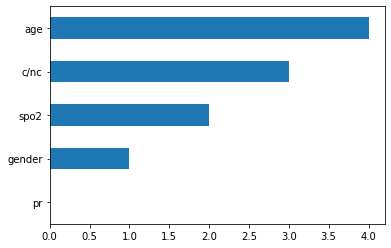

In [27]:
# fisher score telling only pr is not important but we can not drop it as different tests told that pr is important
fisher_scr = fisher_score.fisher_score(df1.drop("oxy_flow", axis = 1)[0:5000].to_numpy(),df1["oxy_flow"][0:5000])
s = pd.Series(fisher_scr,index = df1.drop("oxy_flow", axis = 1).columns)
s.sort_values().plot(kind = "barh")

###### After conducting all the feature selection techniques, we can conclude that there is no featuer to drop

# 6. Model Selection & Training

In [28]:
x = df1.drop("oxy_flow", axis = 1)
y = df1["oxy_flow"]

In [29]:
# spliting the data for training as well as testing purpose
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state=42,test_size=0.35 )

###### We have to split our data into training and testing purpose before going for scaling to skip data leakage.

In [30]:
# scaling to reduce impact of the outliers (fit only on training data)
std = StandardScaler()
arr = std.fit_transform(x_train)
std_x_tr = pd.DataFrame(arr,columns = x_train.columns)
std_x_tr

,age,gender,spo2,pr,c/nc
0,1.671378,-0.714299,0.717687,0.376678,0.511513
1,0.266471,-0.714299,-0.029830,-0.690479,0.511513
2,-0.951115,-0.714299,-1.388950,-0.103543,0.511513
3,0.266471,1.399974,0.717687,1.177045,0.511513
4,1.109415,-0.714299,-0.709390,-0.290295,0.511513
...,...,...,...,...,...
3245,-0.389152,-0.714299,0.581775,-2.824792,0.511513
3246,1.062585,1.399974,0.717687,-0.623782,0.511513
3247,-0.155001,-0.714299,0.717687,0.643467,-1.954983
3248,0.547453,-0.714299,0.717687,0.443375,0.511513


In [31]:
# Now we will scale test data set values
arr2 = std.transform(x_test)
std_x_te= pd.DataFrame(arr2,columns = x_test.columns)
std_x_te

,age,gender,spo2,pr,c/nc
0,-0.529643,-0.714299,0.432272,-0.290295,0.511513
1,0.547453,1.399974,-0.233698,0.976953,0.511513
2,0.594283,-0.714299,-0.233698,0.309980,0.511513
3,-0.716964,-0.714299,-0.165742,0.443375,0.511513
4,1.811869,1.399974,0.717687,0.870237,0.511513
...,...,...,...,...,...
1745,1.062585,-0.714299,0.717687,0.029852,0.511513
1746,-0.576473,-0.714299,0.717687,1.177045,-1.954983
1747,1.156245,-0.714299,0.717687,1.177045,-1.954983
1748,1.203076,-0.714299,-0.016238,-0.156901,0.511513


In [32]:
models = [("linear_regression",LinearRegression()),("DT", DecisionTreeRegressor()),
          ("Random_Forest",RandomForestRegressor()),("KNN",KNeighborsRegressor())]
for name,model in models:
    model.fit(std_x_tr,y_train)
    pred = model.predict(std_x_tr)
    pred1 = model.predict(std_x_te)
    print(f"""the accuracies of {name} model 
          (Training: {r2_score(y_train,pred)}) 
          (Test: {r2_score(y_test,pred1)})""" )
    print(f"""the mse of {name} model 
          (Training: {mean_absolute_error(y_train,pred)}) 
          (Test: {mean_absolute_error(y_test,pred1)}) """)
    print("*"*30)
    

the accuracies of linear_regression model 
          (Training: 0.008875137573596925) 
          (Test: 0.014832011841349746)
the mse of linear_regression model 
          (Training: 12.2721302294162) 
          (Test: 12.415736814413533) 
******************************
the accuracies of DT model 
          (Training: 0.9610635590417821) 
          (Test: -0.9056117005887852)
the mse of DT model 
          (Training: 0.6955384615384615) 
          (Test: 17.39909523809524) 
******************************
the accuracies of Random_Forest model 
          (Training: 0.813408100214667) 
          (Test: -0.1263533495952096)
the mse of Random_Forest model 
          (Training: 5.379730214648599) 
          (Test: 13.562597857047717) 
******************************
the accuracies of KNN model 
          (Training: 0.2091350591803971) 
          (Test: -0.1710991401338302)
the mse of KNN model 
          (Training: 11.461415384615387) 
          (Test: 13.912114285714287) 
*******************

###### Hyper Parameter Tuning for Decision Tree Model

In [33]:
# Hyper parameter tuning
model = DecisionTreeRegressor()
param = {"criterion":["mse","mae"], "max_depth": np.arange(2,30),
         "min_samples_split": np.arange(2,20), "min_samples_leaf": np.arange(1,10),
         "random_state": [42,43,44,45]}
grscv = RandomizedSearchCV(model,param,cv=5)
grscv.fit(std_x_tr,y_train)
grscv.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=2, min_samples_leaf=3,
                      min_samples_split=15, random_state=45)

In [39]:
dt = DecisionTreeRegressor(criterion='mse', max_depth=2, min_samples_leaf=3,
                      min_samples_split=15, random_state=45)
dt.fit(std_x_tr,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=2, min_samples_leaf=3,
                      min_samples_split=15, random_state=45)

In [46]:
y_pred = dt.predict(std_x_tr)
print("R2 Score Training:",r2_score(y_train,y_pred))
print("MAE Training:",mean_absolute_error(y_train,y_pred))

R2 Score Training: 0.014855293025734406
MAE Training: 12.240614169275293


In [47]:
y_pred1 = dt.predict(std_x_te)
print("R2 Score Testing:",r2_score(y_test,y_pred1))
print("MAE Testing:",mean_absolute_error(y_test,y_pred1))

R2 Score Testing: 0.013362167970447647
MAE Testing: 12.436670773211238


###### Pruning for Decision Tree Model

In [42]:
# pre pruning
dt_1 = DecisionTreeRegressor(random_state=45,ccp_alpha=0.0)
dt_1.fit(std_x_tr,y_train)

DecisionTreeRegressor(random_state=45)

In [43]:
#post pruning
dictt = dt_1.cost_complexity_pruning_path(std_x_tr,y_train)
ccp_alphas = dictt["ccp_alphas"]
train_accuracy_list = []
test_accuracy_list = []
for ccp_val in ccp_alphas:
    if ccp_val > 0:
        dt_2 = DecisionTreeRegressor(random_state = 42,ccp_alpha = ccp_val)
        dt_2.fit(std_x_tr,y_train)
        yp1 = dt_2.predict(std_x_tr)
        yp2 = dt_2.predict(std_x_te)
        train_accuracy_list.append(r2_score(y_train,yp1))
        test_accuracy_list.append(r2_score(y_test,yp2))

In [44]:
index = np.where(test_accuracy_list == np.max(test_accuracy_list))
for i in index[0]:
    print(f"at the {ccp_alphas[i]} ccp_alpha value, \nwe will get {train_accuracy_list[i]} training accuracy \nand {test_accuracy_list[i]} testing accuracy")
    print("#"*50)

at the 1.148647820890659 ccp_alpha value, 
we will get 0.011362914539539859 training accuracy 
and 0.007164699889404602 testing accuracy
##################################################


###### Hyper Parameter Tuning for Random Forest Model

In [48]:
model = RandomForestRegressor()
param = {"criterion":["mse","mae"], "max_depth": np.arange(2,30),
         "min_samples_split": np.arange(2,20), "min_samples_leaf": np.arange(1,10),
         "random_state": [42,43,44,45],"n_estimators":np.arange(10,500)}
grscv = RandomizedSearchCV(model,param,cv=5)
grscv.fit(std_x_tr,y_train)
grscv.best_estimator_

RandomForestRegressor(criterion='mse', max_depth=4, min_samples_leaf=7,
                      min_samples_split=9, n_estimators=166, random_state=45)

In [49]:
rf = RandomForestRegressor(criterion='mse', max_depth=4, min_samples_leaf=7,
                      min_samples_split=9, n_estimators=166, random_state=45)
rf.fit(std_x_tr,y_train)

RandomForestRegressor(criterion='mse', max_depth=4, min_samples_leaf=7,
                      min_samples_split=9, n_estimators=166, random_state=45)

In [50]:
y_pred = rf.predict(std_x_tr)
print("R2 Score Training:",r2_score(y_train,y_pred))
print("MAE Training:",mean_absolute_error(y_train,y_pred))

R2 Score Training: 0.05036267781922432
MAE Training: 12.037457655139221


In [51]:
y_pred1 = rf.predict(std_x_te)
print("R2 Score Testing:",r2_score(y_test,y_pred1))
print("MAE Testing:",mean_absolute_error(y_test,y_pred1))

R2 Score Testing: 0.014350067180177617
MAE Testing: 12.449325030752266


In [ ]:
# by doing all the things we can see the goodness of best fit line is not good.
# So, we have to ask for more relevent data from the client

In [54]:
df.head(4)

,age,gender,spo2,pr,c/nc,oxy_flow
95433,79,1,97.0,110.0,1.0,0.0
4575,17,0,NaN,54.0,1.0,29.0
124923,17,0,NaN,49.0,1.0,6.0
64585,41,0,99.0,108.0,1.0,76.0


In [60]:
# for cheking the model
age = 75
gender = 1
spo2 = 24.0
pr = 45.0
cnc = 1


# __________________________________________________________________________________________________________________
#creating an array for testing the user data
test_array = np.zeros(std_x_tr.shape[1])
column_names = std_x_tr.columns
test_array[0] = age
test_array[1] = gender
test_array[2] = spo2
test_array[3] = pr
test_array[4] = cnc


In [61]:
#scaling the user data
array = std.transform([test_array])
array

array([[ 1.3435663 ,  1.39997398, -4.37901611, -3.15827859,  0.5115134 ]])

In [62]:
# predicting the data with Random forest model
rf.predict(array)

array([17.75884326])

In [63]:
#predicting the data with decision tree model
dt.predict(array)

array([18.69047619])

In [70]:
jsondata = {"columns":std_x_tr.columns.tolist()}
jsondata

{'columns': ['age', 'gender', 'spo2', 'pr', 'c/nc']}

In [72]:
#exporting the model for flask operations
with open("Model.pkl", "wb") as f:
    pickle.dump(rf,f)
with open("Scaling.pkl", "wb") as f:
    pickle.dump(std,f)
with open("json_data.json", "w") as f:
    json.dump(jsondata, f)